In [5]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries
import corner 
import pycbc.waveform
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

In [6]:
def trial_model_time(time_array, mass_1, mass_2, luminosity_distance, theta_jn, phase,
         a_1, a_2, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0, 
         **waveform_kwargs):
    """ Modelling the inspital part of the waveform in time domain """
    
    start_frequency = minimum_frequency = waveform_kwargs.get('minimum_frequency', 20.0)
    #maximum_frequency = waveform_kwargs.get('maximum_frequency', frequency_array[-1])
    reference_frequency = waveform_kwargs.get('reference_frequency', 50.0)
    
    start_time = minimum_time = waveform_kwargs.get('minimum_time', time_array[0])
    end_time = maximum_time = waveform_kwargs.get('maximum_time', time_array[-1])
    
    waveform_dictionary = dict(spin_order=-1, tidal_order=-1,
        phase_order=-1, amplitude_order=0)
    
    m1 = mass_1 * bilby.core.utils.solar_mass
    m2 = mass_2 * bilby.core.utils.solar_mass
    
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=theta_jn, phi_jl=phi_jl, tilt_1=tilt_1, tilt_2=tilt_2,
        phi_12=phi_12, a_1=a_1, a_2=a_2, mass_1=m1, mass_2=m2,
        reference_frequency=reference_frequency, phase=phase)
    
    longitude_ascending_nodes = 0.0
    mean_per_ano = 0.0
    
    hpt, hct = pycbc.waveform.get_td_waveform(approximant="NRSur7dq4",
                                        mass1=mass_1,
                                 mass2=mass_2,
                                 a1= a_1, a2= a_2,
                                 delta_t=1.0/4096,
                                 f_lower=20)
    
    #h_plus = np.zeros_like(time_array, dtype=complex)
    #h_cross = np.zeros_like(time_array, dtype=complex)
    
    if len(hpt.data.data) > len(time_array):
        h_plus = hpt.resize(len(time_array))
        h_cross = hct.resize(len(time_array))
    else:
        h_plus = hpt.cyclic_time_shift(hpt.start_time)
        h_cross = hct.cyclic_time_shift(hct.start_time)

    return h_plus

In [7]:
time_of_event = 1126259462.4
tg = 1126259462.4
#plt.plot(t,model,color='b',label='NRSur7dq4',alpha=0.5)
#t1 = np.linspace(tg-4,tg,100)
#model1 = np.array(trial_model_time(t1,30, 30, 400, 0, 1.3,
#          0.3, 0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0))
#t2 = np.linspace(tg-4,tg,10000)
#model2 = np.array(trial_model_time(t2,30, 30, 400, 0, 1.3,
#          0.3, 0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0))
#plt.plot(t,model,color='b',label='1000 Points')
#plt.plot(t1,model1,color='r',label='100 Points',alpha=0.5)
#plt.plot(t2,model2,color='g',label='10000 Points',alpha=0.5)
#plt.axvline(tg,color='k',label='GPS Time')
#plt.legend()
#plt.show()

In [9]:
#Getting data 
merger = Merger("GW150914")
strain = merger.strain('H1')
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/4096)
#pylab.plot(strain.sample_times, strain)
#pylab.xlabel('Time (s)')
#pylab.show()

In [10]:
conditioned = strain.crop(2, 2)
#pylab.plot(conditioned.sample_times, conditioned)
#pylab.xlabel('Time (s)')
#pylab.show()

In [6]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [11]:
t = np.linspace(tg-4,tg,4*4096)
model = trial_model_time(t,30, 30, 400, 0, 1.3,
         0.3, 0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)
model.resize(len(conditioned))
#hp, hc = pycbc.waveform.get_td_waveform(approximant="NRSur7dq4",mass1=30,mass2=30,a1= 0.3, a2= 0.4,delta_t=1.0/4096,f_lower=20)
#hp.resize(len(conditioned))

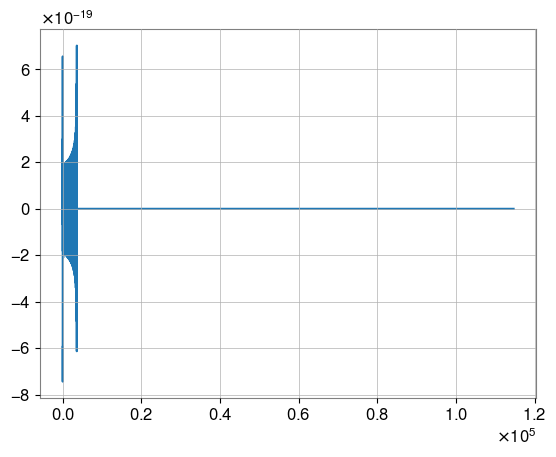

In [16]:
plt.plot(model)

Text(0, 0.5, 'Strain')

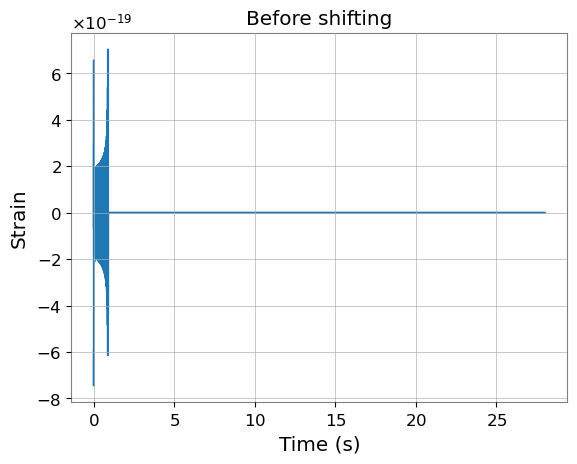

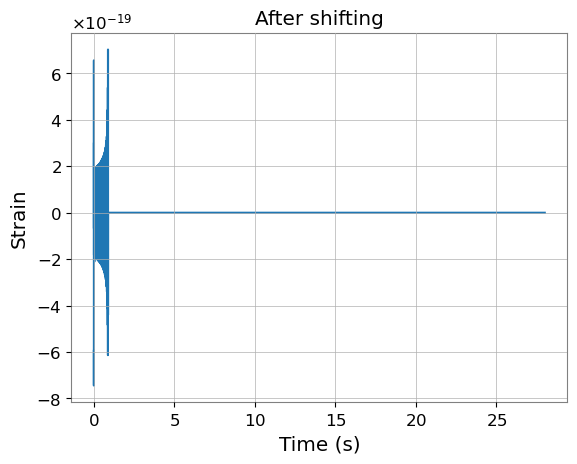

In [8]:
pylab.figure()
pylab.title('Before shifting')
pylab.plot(model.sample_times, model)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
template = model.cyclic_time_shift(model.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

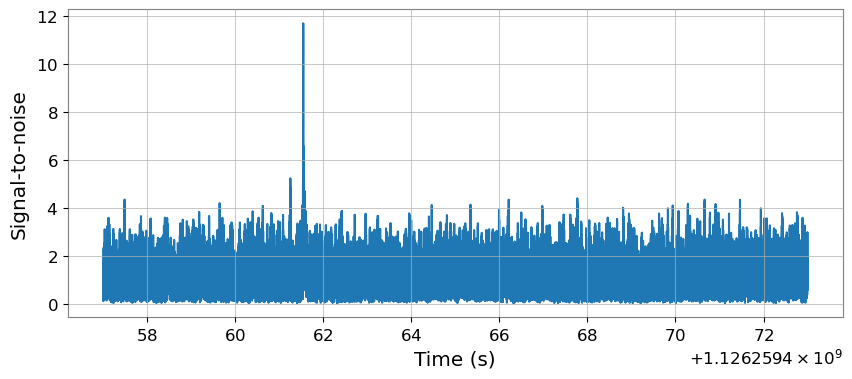

In [9]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

In [10]:
from pycbc.filter import sigma
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

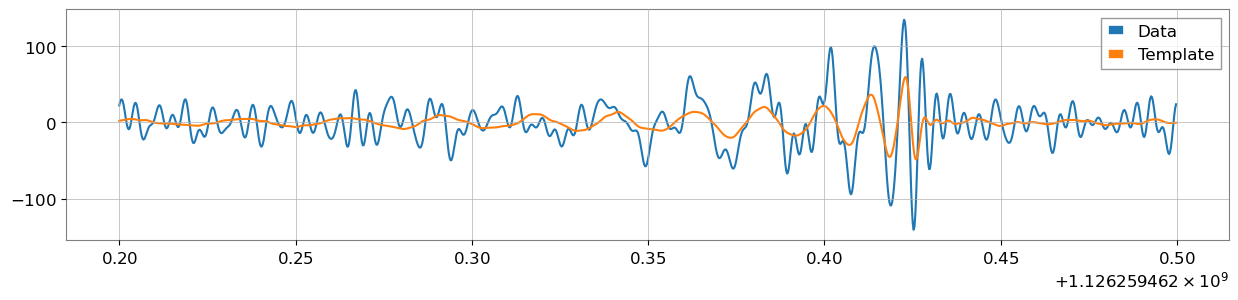

In [11]:
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

In [3]:
bilby.gw.source.lal_binary_black_hole

<function bilby.gw.source.lal_binary_black_hole(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, **kwargs)>

In [37]:
t = np.linspace(tg-4,tg,4*4096)

model = trial_model_time(t,50, 300, 400, 0, 1.3,
         0.3, 0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)

In [38]:
len(model)

826

In [32]:
 hpf, hcf = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                                        mass1=10,
                                 mass2=70,
                                 a1= 0, a2= 0,
                                 delta_f=1.0/4,
                                 f_lower=20)

In [33]:
len(hpf)

220